# Bus AVL Project

Ehab Ebeid

## Setup

In [1]:
from __future__ import division, print_function
import numpy as np, pprint
import matplotlib.pyplot as plt
import math

## Data Exploration

The dataset can be very large. First, set the parameters used to specify which data to import.

In [2]:
# minimum and maximum trip start datetime, in the format "yyyy-mm-dd hh:mi:ss", local time
FROM_DT = '2018-06-13 10:00:00'
TO_DT   = '2018-06-13 12:00:00'

# a single route pattern, which encodes the bus route and direction
ROUTE_PATTERN = '7901'

The AVL data is located in a local Microsoft SQL Server database. Connect to the database and import a selection of the data using the parameters above.

In [3]:
import pyodbc 
import pandas as pd

def get_data(from_dt, to_dt, route_pattern):
    # connect to local database
    cnxn = pyodbc.connect(Trusted_Connection='yes', 
                          driver = '{SQL Server}',
                          server = 'EHAB\SQLEXPRESS', 
                          database = 'raw_nav')
    
    # join the tables route_run and gps_reading, using the filters specified above
    query = """select 
                r.id as route_run_id,
                r.route_pattern,
                r.bus_id,
                r.svc_date,
                r.trip_start_datetime,
                g.id as gps_reading_id,
                g.lat_fixed as lat,
                g.lon_fixed as lon,
                g.heading_deg,
                g.door_state,
                g.vehicle_state,
                g.odo_feet,
                g.time_seconds,
                g.sat_count,
                g.stop_window_data,
                r.invalid

            from raw_nav.dbo.route_run as r
            join raw_nav.dbo.gps_reading as g
            on r.id = g.route_run_id

            where trip_start_datetime between '{start}' and '{end}'
              and route_pattern = '{pattern}'
            ;
            """.format(start=from_dt, end=to_dt, pattern=route_pattern)

    # grab as a pandas dataframe
    return pd.read_sql_query(query, cnxn)

        
df = get_data(FROM_DT, TO_DT, ROUTE_PATTERN)

Let's take a look!

In [4]:
# summarise the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13962 entries, 0 to 13961
Data columns (total 16 columns):
route_run_id           13962 non-null int64
route_pattern          13962 non-null object
bus_id                 13962 non-null object
svc_date               13962 non-null object
trip_start_datetime    13962 non-null datetime64[ns]
gps_reading_id         13962 non-null int64
lat                    13962 non-null float64
lon                    13962 non-null float64
heading_deg            13962 non-null int64
door_state             13962 non-null object
vehicle_state          13962 non-null object
odo_feet               13962 non-null int64
time_seconds           13962 non-null int64
sat_count              13962 non-null int64
stop_window_data       348 non-null object
invalid                13962 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(7), object(6)
memory usage: 1.7+ MB


In [5]:
# first five rows
df.head()

,route_run_id,route_pattern,bus_id,svc_date,trip_start_datetime,gps_reading_id,lat,lon,heading_deg,door_state,vehicle_state,odo_feet,time_seconds,sat_count,stop_window_data,invalid
0,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088010,38.994025,-77.030545,220,C,M,0,0,6,None,0
1,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088011,38.993985,-77.030590,199,C,M,11,1,5,None,0
2,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088012,38.993940,-77.030619,178,C,M,29,2,6,None,0
3,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088013,38.993940,-77.030619,178,C,M,30,2,6,X-1,0
4,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088014,38.993940,-77.030619,178,C,M,31,2,6,E00,0


It would be useful to see how many route runs, or trips, are included in the data.

In [6]:
ntrips = df.trip_start_datetime.unique().shape
print (ntrips)

(10,)


This is the number of trips with start times given by the parameters above.

It would be useful to plot them out as time-space diagrams. Doing so is easiest with timestamps for each GPS reading, which we are missing. Instead we have the `time_seconds` field, which is the number of seconds elapsed since the start of the trip. Let's create a `timestamp` field.

In [7]:
def add_timestamps(df):
    df['timestamp'] = df.trip_start_datetime + pd.to_timedelta(df['time_seconds'], unit='s')
    return df

df = add_timestamps(df)

df.head()

,route_run_id,route_pattern,bus_id,svc_date,trip_start_datetime,gps_reading_id,lat,lon,heading_deg,door_state,vehicle_state,odo_feet,time_seconds,sat_count,stop_window_data,invalid,timestamp
0,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088010,38.994025,-77.030545,220,C,M,0,0,6,None,0,2018-06-13 10:12:30
1,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088011,38.993985,-77.030590,199,C,M,11,1,5,None,0,2018-06-13 10:12:31
2,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088012,38.993940,-77.030619,178,C,M,29,2,6,None,0,2018-06-13 10:12:32
3,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088013,38.993940,-77.030619,178,C,M,30,2,6,X-1,0,2018-06-13 10:12:32
4,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088014,38.993940,-77.030619,178,C,M,31,2,6,E00,0,2018-06-13 10:12:32


That's more like it! Now we can plot the trips.

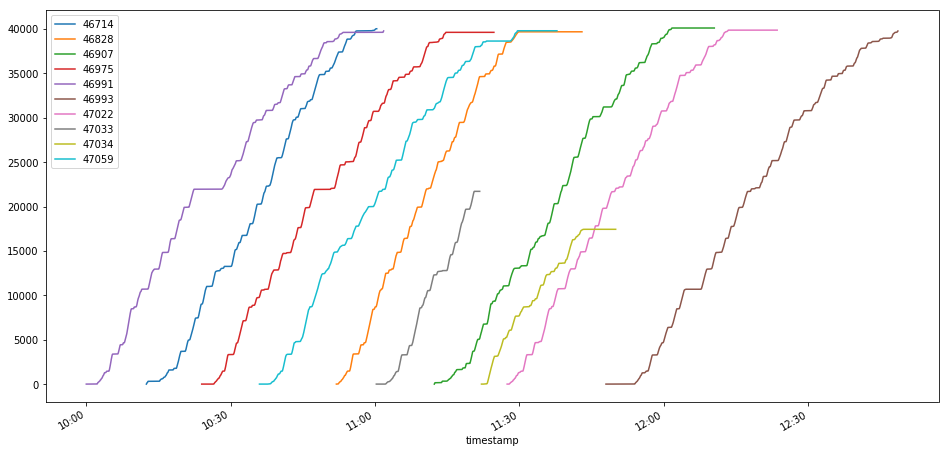

In [8]:
import matplotlib.dates as mdates

# time-space diagrams of the trips returned
fig, ax = plt.subplots()
for name, group in df.groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax, label=name)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

We notice that most trips have approximately the same maximum odometer reading, at around 40,000 feet. This is to be expected since they are all on the same route and direction.

**However**, two trips stand out as erroneous: route run 47033 (grey) and 47034 (light green) are shorter than the others. Because route run 47034 starts at around the same time that 47033 ends, it is reasonable to conclude that this is a case of the bus odometer resetting to zero mid-trip. This is by far the most common case of erroneous data.

<div class='tableauPlaceholder' id='viz1546091739629' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bu&#47;BusAVL&#47;Dashboard&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='views&#47;BusAVL&#47;Dashboard?:embed=y&amp;:display_count=y&amp;publish=yes' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bu&#47;BusAVL&#47;Dashboard&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1546091739629');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='800px';vizElement.style.height='527px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Data Cleaning

### Remove trips with odometer resets to zero

In [9]:
def remove_short_trips(df, display=True):
    df_cleaned = df.copy()
    # calculate median odometer reading m
    max_odos = {}
    if display:
        print("trip  max odo")
    
    for name, group in df_cleaned.groupby('route_run_id'):
        max_odo = group['odo_feet'].max()
        if display:
            print(name, max_odo)
        max_odos[name] = max_odo

    max_odo_values = list(max_odos.values())
    m = np.median(max_odo_values)

    
    # mark trips with odometer readings of >1.05m or <0.95m
    for i, row in df_cleaned.iterrows():
        if max_odos[row['route_run_id']] > 1.05*m or max_odos[row['route_run_id']] < 0.95*m:
            df_cleaned.at[i,'invalid'] = 1
    
    print()
    print("Median =", m)
    
    return df_cleaned

df_cleaned = remove_short_trips(df)

trip  max odo
46714 40027
46828 39681
46907 40108
46975 39621
46991 39778
46993 39771
47022 39869
47033 21710
47034 17435
47059 39800

Median = 39774.5


In [10]:
df_cleaned.to_csv("bus_avl_cleaned.csv")

In [11]:
#TODO: Other data cleaning (?)

Let us check now if the problematic trips have been removed.

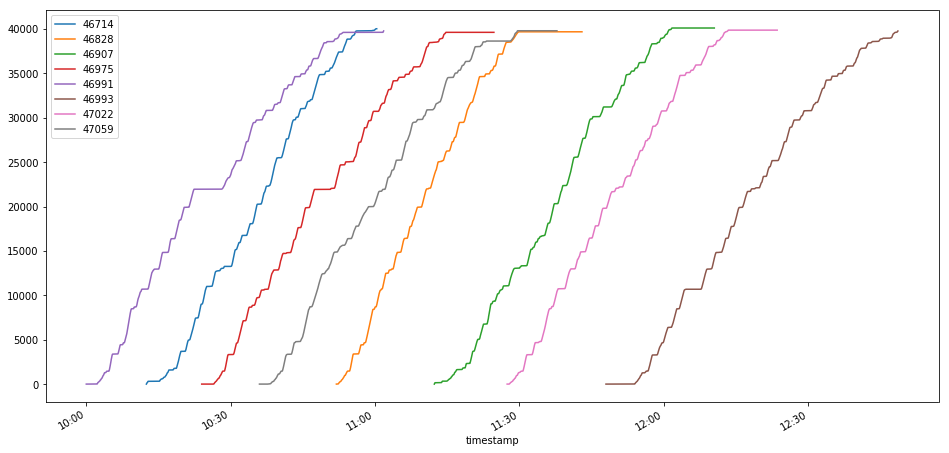

In [12]:
fig, ax = plt.subplots()
for name, group in df_cleaned.loc[df_cleaned['invalid'] == 0].groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax, label=name)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

Running the same steps on the entire day's data will let us know if this data cleaning task is successful.

In [13]:
FROM_DT = '2018-06-13 00:00:00' # '2018-06-13 10:00:00'
TO_DT   = '2018-06-13 23:59:59' # '2018-06-13 12:00:00'

df_all = get_data(FROM_DT, TO_DT, ROUTE_PATTERN)
df_all = add_timestamps(df_all)

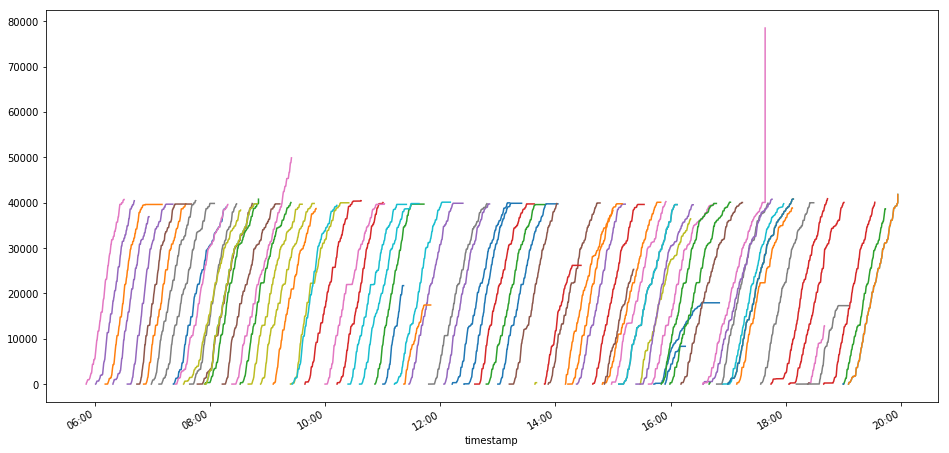

In [14]:
fig, ax = plt.subplots()
for name, group in df_all.loc[df_all['invalid'] == 0].groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.get_legend().remove()

In [15]:
df_all_cln = remove_short_trips(df_all, display=False)


Median = 39746.0


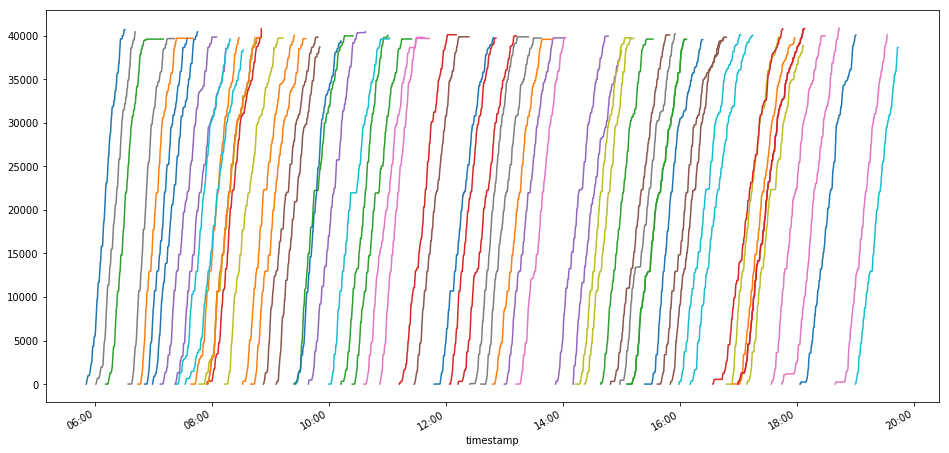

In [16]:
fig, ax = plt.subplots()
for name, group in df_all_cln.loc[df_all_cln['invalid'] == 0].groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.get_legend().remove()

What a beauty! No more strange trips as far as I can tell.

## Reduce Data Resolution

In [17]:
df_all_cln.head()

,route_run_id,route_pattern,bus_id,svc_date,trip_start_datetime,gps_reading_id,lat,lon,heading_deg,door_state,vehicle_state,odo_feet,time_seconds,sat_count,stop_window_data,invalid,timestamp
0,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077557,38.937462,-77.024495,181,C,S,0,0,7,None,1,2018-06-13 15:42:34
1,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077558,38.937462,-77.024495,181,C,S,0,0,6,X-1,1,2018-06-13 15:42:34
2,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077559,38.937462,-77.024495,181,C,S,0,0,6,E08,1,2018-06-13 15:42:34
3,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077560,38.937468,-77.024488,173,C,M,11,65,7,None,1,2018-06-13 15:43:39
4,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077561,38.937427,-77.024473,164,C,M,24,69,7,None,1,2018-06-13 15:43:43


In [18]:
df_all_cln['30s'] = 0
df_all_cln['15s'] = 0
df_all_cln['5s'] = 0
for name, group in df_all_cln.groupby(['route_run_id']):
    for index, row in group.iterrows():
        if index%30 == 0:
            df_all_cln.at[index, '30s'] = 1
        if index%15 == 0:
            df_all_cln.at[index, '15s'] = 1
        if index%5 == 0:
            df_all_cln.at[index, '5s'] = 1
        
        if row['stop_window_data']:
            df_all_cln.at[index, '5s'] = 1
            df_all_cln.at[index, '15s'] = 1
            df_all_cln.at[index, '30s'] = 1
            
df_all_cln.head(30)

,route_run_id,route_pattern,bus_id,svc_date,trip_start_datetime,gps_reading_id,lat,lon,heading_deg,door_state,vehicle_state,odo_feet,time_seconds,sat_count,stop_window_data,invalid,timestamp,30s,15s,5s
0,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077557,38.937462,-77.024495,181,C,S,0,0,7,None,1,2018-06-13 15:42:34,1,1,1
1,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077558,38.937462,-77.024495,181,C,S,0,0,6,X-1,1,2018-06-13 15:42:34,1,1,1
2,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077559,38.937462,-77.024495,181,C,S,0,0,6,E08,1,2018-06-13 15:42:34,1,1,1
3,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077560,38.937468,-77.024488,173,C,M,11,65,7,None,1,2018-06-13 15:43:39,0,0,0
4,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077561,38.937427,-77.024473,164,C,M,24,69,7,None,1,2018-06-13 15:43:43,0,0,0
5,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077562,38.937378,-77.024462,164,C,M,41,71,7,None,1,2018-06-13 15:43:45,0,0,1
6,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077563,38.937322,-77.024458,168,C,M,60,73,8,None,1,2018-06-13 15:43:47,0,0,0
7,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077564,38.937288,-77.024460,173,C,M,71,74,8,None,1,2018-06-13 15:43:48,0,0,0
8,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077565,38.937258,-77.024462,177,C,M,81,75,8,None,1,2018-06-13 15:43:49,0,0,0
9,46707,7901,6426,06/13/18,2018-06-13 15:42:34,64077566,38.937230,-77.024467,181,C,M,91,76,8,None,1,2018-06-13 15:43:50,0,0,0


## Analysis

### Segment Analysis

In [19]:
# Map stop names to stop numbers
stop_names = ["", 
              "Silver Spring Station", 
              "Eastern Ave", 
              "Butternut St",
              "Piney Branch Rd",
              "Rock Creek Ford Rd", 
              "Kennedy St", 
              "Decatur St", 
              "New Hampshire Ave", 
              "Columbia Rd", 
              "Howard Pl", 
              "T St", 
              "R St", 
              "N St", 
              "H St", 
              "Pennsylvania Ave", 
              "Constitution Ave"]

In [20]:
def get_segments(df):
    segments = {}
    for name, group in df.loc[df['invalid'] == 0].groupby('route_run_id'):
        on = False
        segment = {}
        last_window = 0
        stationary = False
        door_open = False
        st_secs = 0
        open_secs = 0

        for i, row in group.iterrows():
            if row['stop_window_data'] == 'E02':
                # avoid start of trip
                on = True
                last_window = 2 # last window entrance code

            if on:
                if row['stop_window_data']:
                    # segment ID
                    if row['stop_window_data'][0] == 'E':
                        # entering stop window
                        # segment that just ended is pre stop
                        last_window = int(row['stop_window_data'][1:])
                        segment_id = str(last_window)+"P"

                    elif row['stop_window_data'][0] == 'X':
                        # exiting stop window
                        # segment that just ended is stop
                        segment_id = str(last_window)+"S"

                    if segment: # check if segment dict is not empty
                        # end previous segment
                        segment['out_ts'] = prev_row['timestamp']
                        segment['duration_secs'] = (segment['out_ts'] - segment['in_ts']).total_seconds()
                        segment['out_odo'] = int(prev_row['odo_feet'])
                        segment['dist_feet'] = segment['out_odo'] - segment['in_odo']

                        segment['stationary_secs'] = st_secs
                        segment['door_open_secs'] = open_secs

                        # identify errors
                        if segment['duration_secs'] > 10 and segment['dist_feet'] > 10:
                            #speed calculation here to avoid division by zero
                            segment['avg_speed_ftps'] = segment['dist_feet']/segment['duration_secs']

                            # add segment to dict
                            if not segments.get(segment_id):
                                segments[segment_id] = []
                            segments[segment_id].append(segment)

                    # start new segment
                    st_secs = 0
                    open_secs = 0
                    segment = {}
                    segment['in_ts'] = row['timestamp']
                    segment['bus_id'] = row['bus_id']
                    segment['route_run_id'] = row['route_run_id']
                    segment['in_ts'] = row['timestamp']
                    segment['in_odo'] = int(row['odo_feet'])

                # count seconds with open door
                if stationary:
                    secs_since_prev = int(row['time_seconds']) - int(prev_row['time_seconds'])
                    st_secs += secs_since_prev
                stationary = True if row['vehicle_state'] == 'S' else False

                # count seconds with stationary vehicle
                if door_open:
                    secs_since_prev = int(row['time_seconds']) - int(prev_row['time_seconds'])
                    open_secs += secs_since_prev
                door_open = True if row['door_state'] == 'O' else False

            prev_row = row
    return segments

In [21]:
segments = get_segments(df_all_cln)

In [22]:
# segments for resolution testing
segments_30s = get_segments(df_all_cln[df_all_cln['30s'] == 1])
segments_15s = get_segments(df_all_cln[df_all_cln['15s'] == 1])
segments_5s  = get_segments(df_all_cln[df_all_cln['5s'] == 1])

In [23]:
pp = pprint.PrettyPrinter()
pp.pprint(segments_5s['10P'][0:2])

[{'avg_speed_ftps': 37.723404255319146,
  'bus_id': '6451',
  'dist_feet': 1773,
  'door_open_secs': 0,
  'duration_secs': 47.0,
  'in_odo': 25316,
  'in_ts': Timestamp('2018-06-13 07:15:48'),
  'out_odo': 27089,
  'out_ts': Timestamp('2018-06-13 07:16:35'),
  'route_run_id': 46710,
  'stationary_secs': 0},
 {'avg_speed_ftps': 25.213333333333335,
  'bus_id': '6451',
  'dist_feet': 1891,
  'door_open_secs': 0,
  'duration_secs': 75.0,
  'in_odo': 25621,
  'in_ts': Timestamp('2018-06-13 08:59:37'),
  'out_odo': 27512,
  'out_ts': Timestamp('2018-06-13 09:00:52'),
  'route_run_id': 46712,
  'stationary_secs': 0}]


In [24]:
# pp.pprint(segments)

In [25]:
cols = ['seg_id', 'type', 'stop_n', 'segment_name', 'route_run_id', 'resolution',
        'speed',
        'door_open', 
        'stationary']

res_comparison = pd.DataFrame(columns=cols)

for res in [1, 5, 15, 30]:
    if res == 1:
        segments = segments
    elif res == 5:
        segments = segments_5s
    elif res == 15:
        segments == segments_15s
    elif res == 30:
        segments = segments_30s
    
    for seg_id, segment_list in segments.items():
        
        stop_n = int(seg_id[:-1])
        if "S" in seg_id:
            tp = "S"
            seg_name = stop_names[int(stop_n)]
        else:
            tp = "P"
            seg_name = stop_names[int(stop_n)-1] + " to " + stop_names[int(stop_n)]
        for segment_run in segment_list:
            rrid = segment_run['route_run_id']
            speed = segment_run['avg_speed_ftps']
            door_open = segment_run['door_open_secs']
            stationary = segment_run['stationary_secs']
            
            rows = [seg_id, tp, stop_n, seg_name, rrid, res, speed, door_open, stationary]
            res_comparison = res_comparison.append(pd.DataFrame([rows], columns=cols),ignore_index=True)

res_comparison.head()


,seg_id,type,stop_n,segment_name,route_run_id,resolution,speed,door_open,stationary
0,2S,S,2,Eastern Ave,46710,1,11.033333,7,13
1,2S,S,2,Eastern Ave,46712,1,9.864865,11,20
2,2S,S,2,Eastern Ave,46714,1,11.903226,5,12
3,2S,S,2,Eastern Ave,46716,1,9.046512,11,20
4,2S,S,2,Eastern Ave,46718,1,12.178571,3,10


In [26]:
res_comparison.to_csv("res_comparison.tsv", sep='\t')

### Analysis Using 1-second Resolution

In [34]:
segments = get_segments(df_all_cln)

In [35]:
segment_durations = {}
segment_dists = {}
segment_speeds = {}
segment_door_open = {}
segment_stationary = {}
for key, segment_list in segments.items():
    for run in segment_list:
        if not segment_durations.get(key):
            segment_durations[key] = []
        segment_durations[key].append(run['duration_secs'])
        
        if not segment_dists.get(key):
            segment_dists[key] = []
        segment_dists[key].append(run['dist_feet'])
        
        if not segment_speeds.get(key):
            segment_speeds[key] = []
        segment_speeds[key].append(run['avg_speed_ftps'])
        
        if not segment_door_open.get(key):
            segment_door_open[key] = []
        segment_door_open[key].append(run['door_open_secs'])
        
        if not segment_stationary.get(key):
            segment_stationary[key] = []
        segment_stationary[key].append(run['stationary_secs'])

In [36]:
def show_segment_hists(segment_dict, name, units=""):
    size = len(segment_dict)
    rows = math.ceil(size/2) # of rows
    sbwidth = 15
    sbheight = sbwidth*5
    f, axarr = plt.subplots(rows, 2, figsize = (sbwidth, sbheight))
    r = 0
    c = 0

    for key, l in segment_dict.items():
        max_l = max(l)
        norm_l = [i/max_l*100 for i in l]

        #create title
        stop_n = key[:-1]
        if key[-1] == "S":
            title = stop_names[int(stop_n)] + " Stop"
                    
            color = "firebrick"
        else:
            title = "Segment Between " + stop_names[int(stop_n)-1] + " and " + stop_names[int(stop_n)]
            color = "darkblue"
            
        # add mean and median below title
        title = title + "\n mean=" +\
                "{:.1f}".format(np.mean(l)) +\
                ", median=" + "{:.1f}".format(np.median(l)) +\
                ", sd=" + "{:.2f}".format(np.std(l))

        #plot!
        ax = axarr[r, c]
        ax.set_title(title)
        
        if int(max_l/22) > 0:
            step = int(max_l/22)
        else:
            step = 1
        
        ax.hist(norm_l, color=color, bins = range(0,110,5), align="left")
        # ax.hist(l, color=color, bins = range(0,int(1.1*max_l),step), align="left")
        ax.set_xlabel(name + " % of " + str(int(max_l)) + " " + units + "\n")
        # ax.set_xlabel(name + " (" + units + ")\n")
        ax.set_ylabel("Number of Runs")

        if c == 1: r += 1
        if c == 0: c = 1
        else: c = 0

    f.subplots_adjust(hspace=.35, wspace=.2)

### Distance

This marks the distance covered by the bus through each segment, as calculated through the bus odometer.

As expected the distance in the non-stop segments is fairly consistent, confirming that the stop windows are a consistent way of dividing the routes.

For the segments containing stops, however, they are marked by a fair degree of variation, indicating that there is a bit of inconsistency in when the flags marking entries into and exits out of a stop window is raised.

Distance of the segment around stop 16 is all over the place! This makes sense as the AVL system often does not know when to mark the end of a trip properly.

I am not entirely sure why there are so many outliers for stop 2 and stop 3.

**TODO**  
I need to figure out whether or not to exclude some segment runs based on their distance being an outlier. Stop 16 should most definitely be excluded.

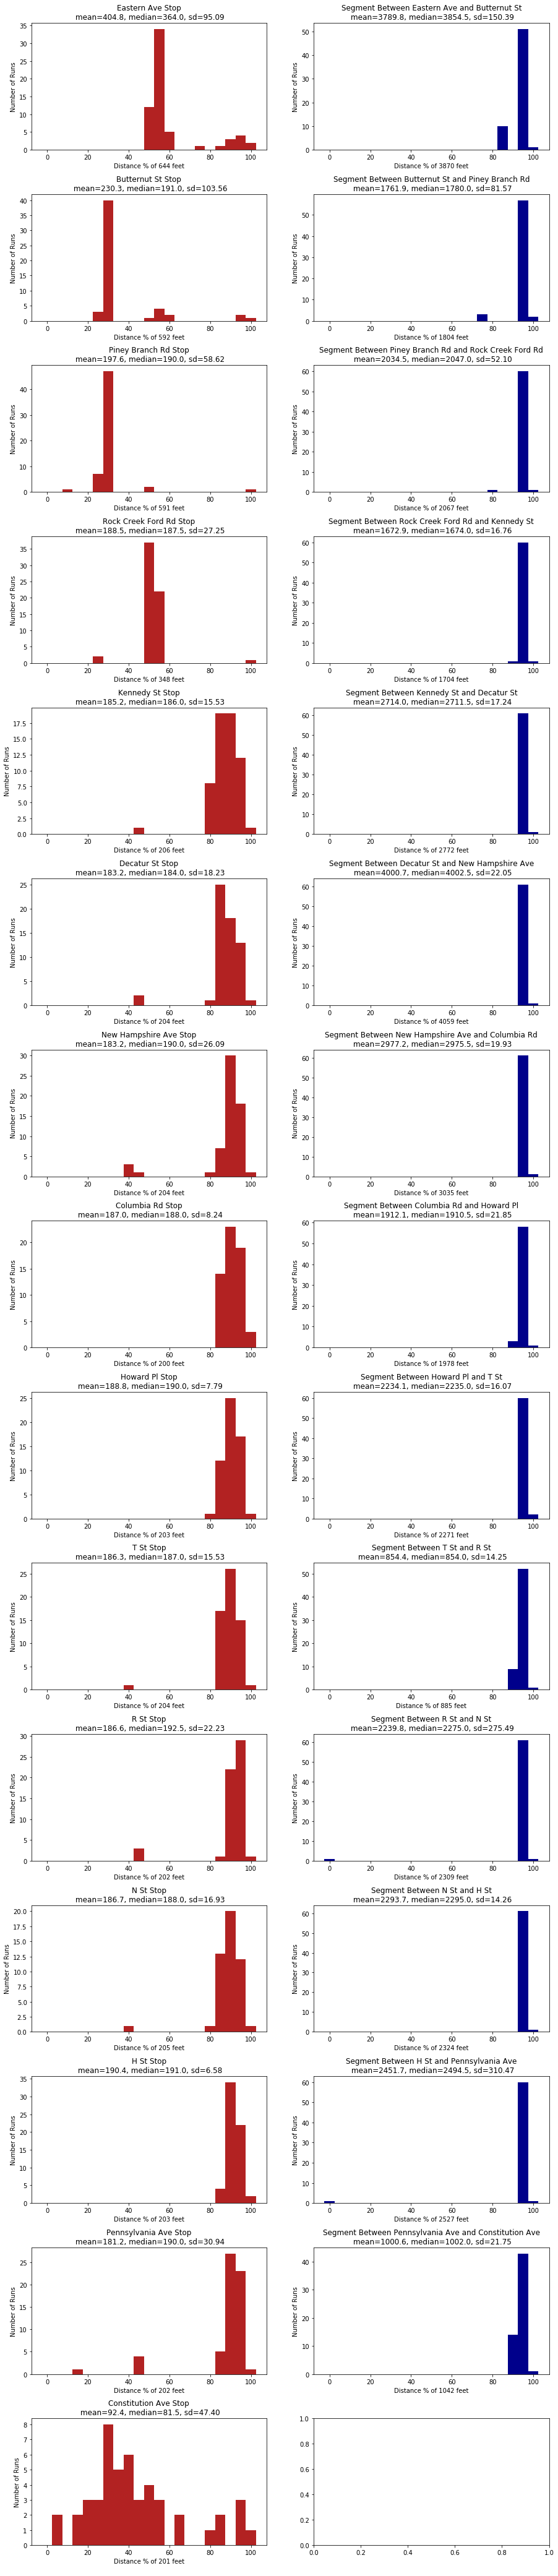

In [37]:
show_segment_hists(segment_dists, "Distance", "feet")

### Duration

This marks the duration of time passed through each segment run as calculated by the bus's seconds counter.

The histograms seem to be largely normally distributed, with some tails towards the longer (more time-consuming) ends. Some segments, for example before the segment between stops 9 and 10, seem to be bimodal. Perhaps another factor, such as peak/off-peak, is a predictor of which of the two modes a segment run belongs to?

The time spent in the stop windows is on average less than the time spent between them. This being said, the difference is not large and as such the average speed within the stop window is expected to be smaller, as the stop windows constitute a comparatively shorter distance than the segments between stops. The speed analysis, which is next, will elaborate on that.

Stop 16 is really funky. We can exclude it.

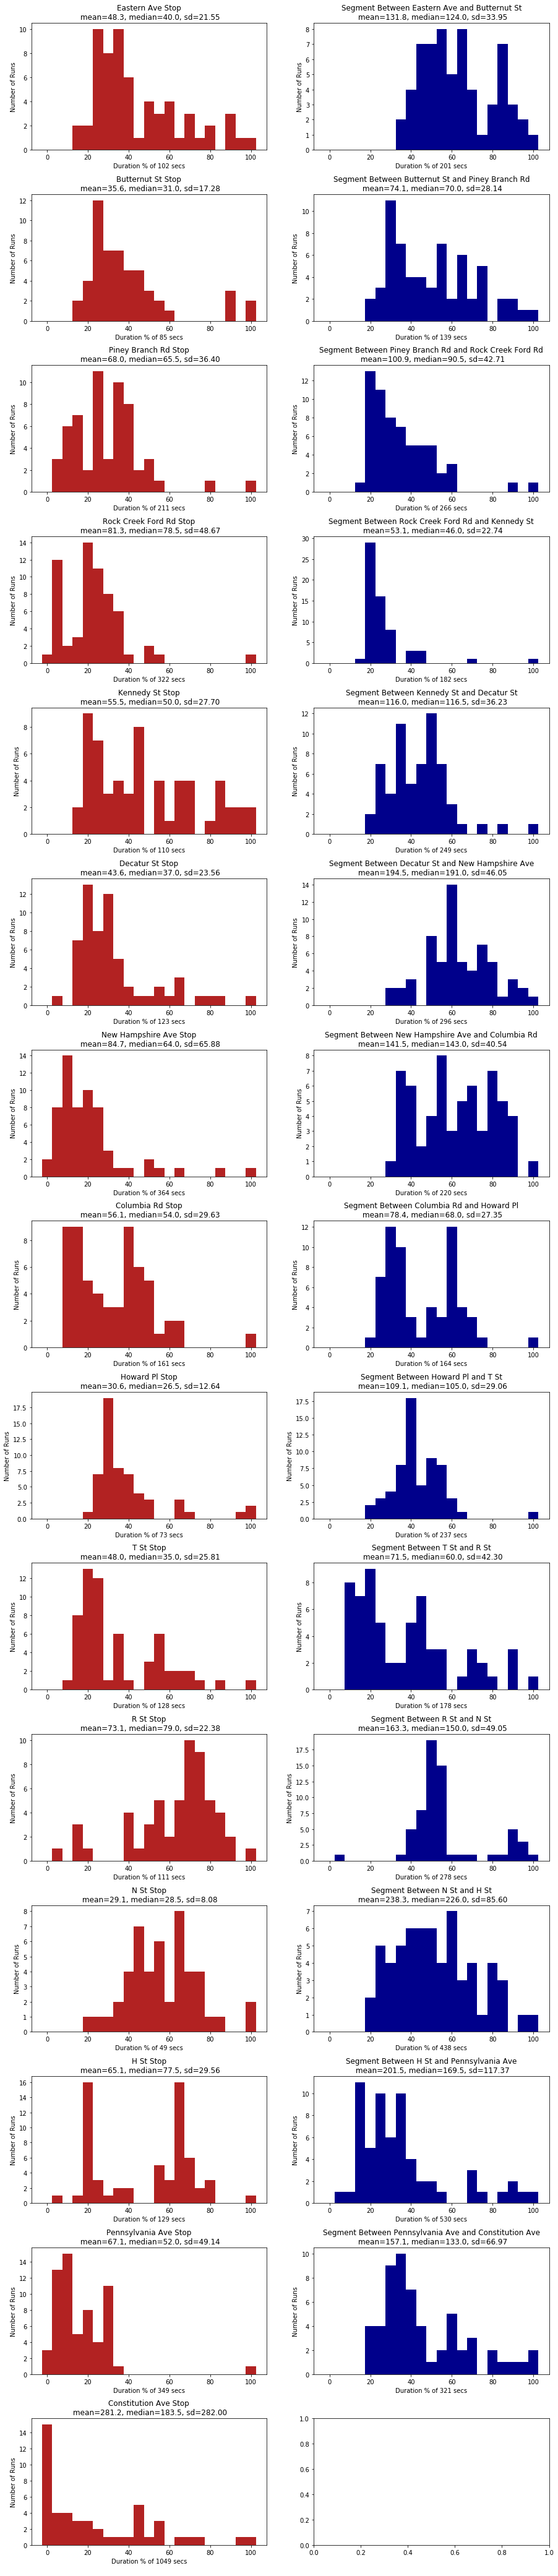

In [38]:
show_segment_hists(segment_durations, "Duration", "secs")

### Speed

The speed is considerably lower inside the stop windows. This suggests that the bus slows down considerably around the stop and that there is often a large dwell time. This can be further corroborated using the bus stationary/bus door open measures below.

Since the distance is relatively constant, we would expect this measure to be distributed very similarly to the above distributions for duration. And they are. 

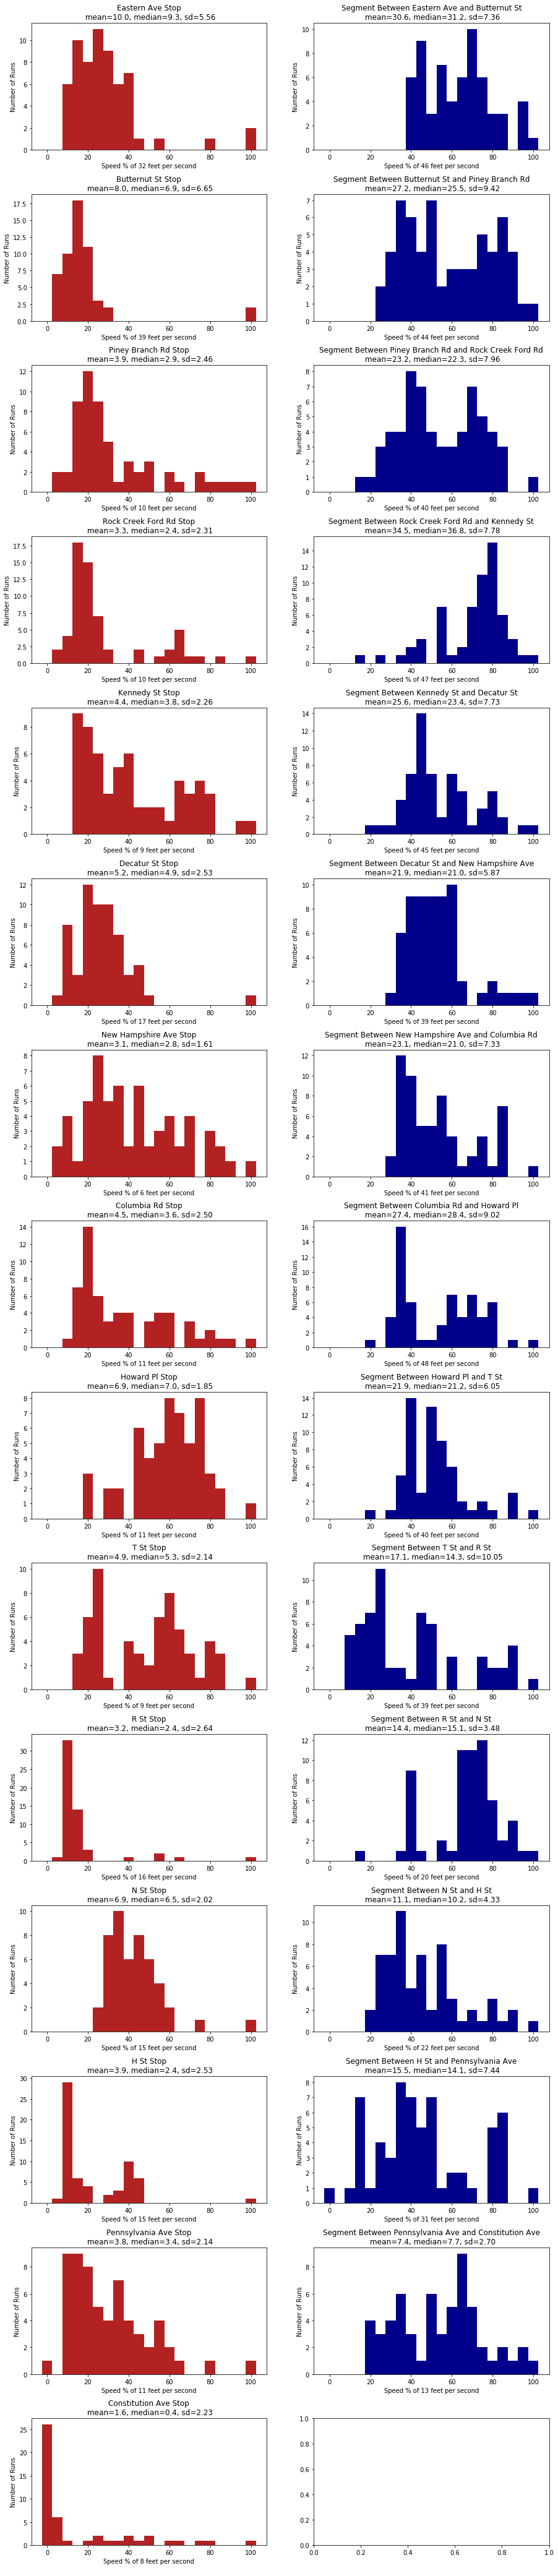

In [39]:
show_segment_hists(segment_speeds, "Speed", "feet per second")

As expected (and hoped), the vast majority of data points between stops have a value of zero for this metric. This is good, we wouldn't want the bus to be running between stops with the door open. However there remain segment runs for which the system reports that the door is open momentarily (e.g. for 2 seconds in the segment between stops 9 and 10) or for a very, very long time (e.g. for 97 seconds between stops 5 and 6).

What is going on when the bus reports that the door is open between stops? I am not entirely sure if these are AVL system failures, door sensor failures, or the door is indeed open for all this time (for example due to some type of problem that caused the operator to stop the vehicle mid-route, but the AVL system was still on).

Data cleaning options:
- include only stationary and door open in this metric, and exclude door open while vehicle is moving, and see what happens
- exclude segment runs for which bus door is open any amount of time between stops

More interesting for the purposes of my analysis, however, is the time elapsed with the door open within the stop windows. This, along with the following metric (time elapsed with vehicle stationary), provides a good proxy for dwell time.

Most of the histograms here seem to be normally distributed with a tail skewing the distribution towards a higher mean. The higher-valued observations are likely due to times when there is a longer dwell time due to a high number of passengers getting on and off. Other explanations?

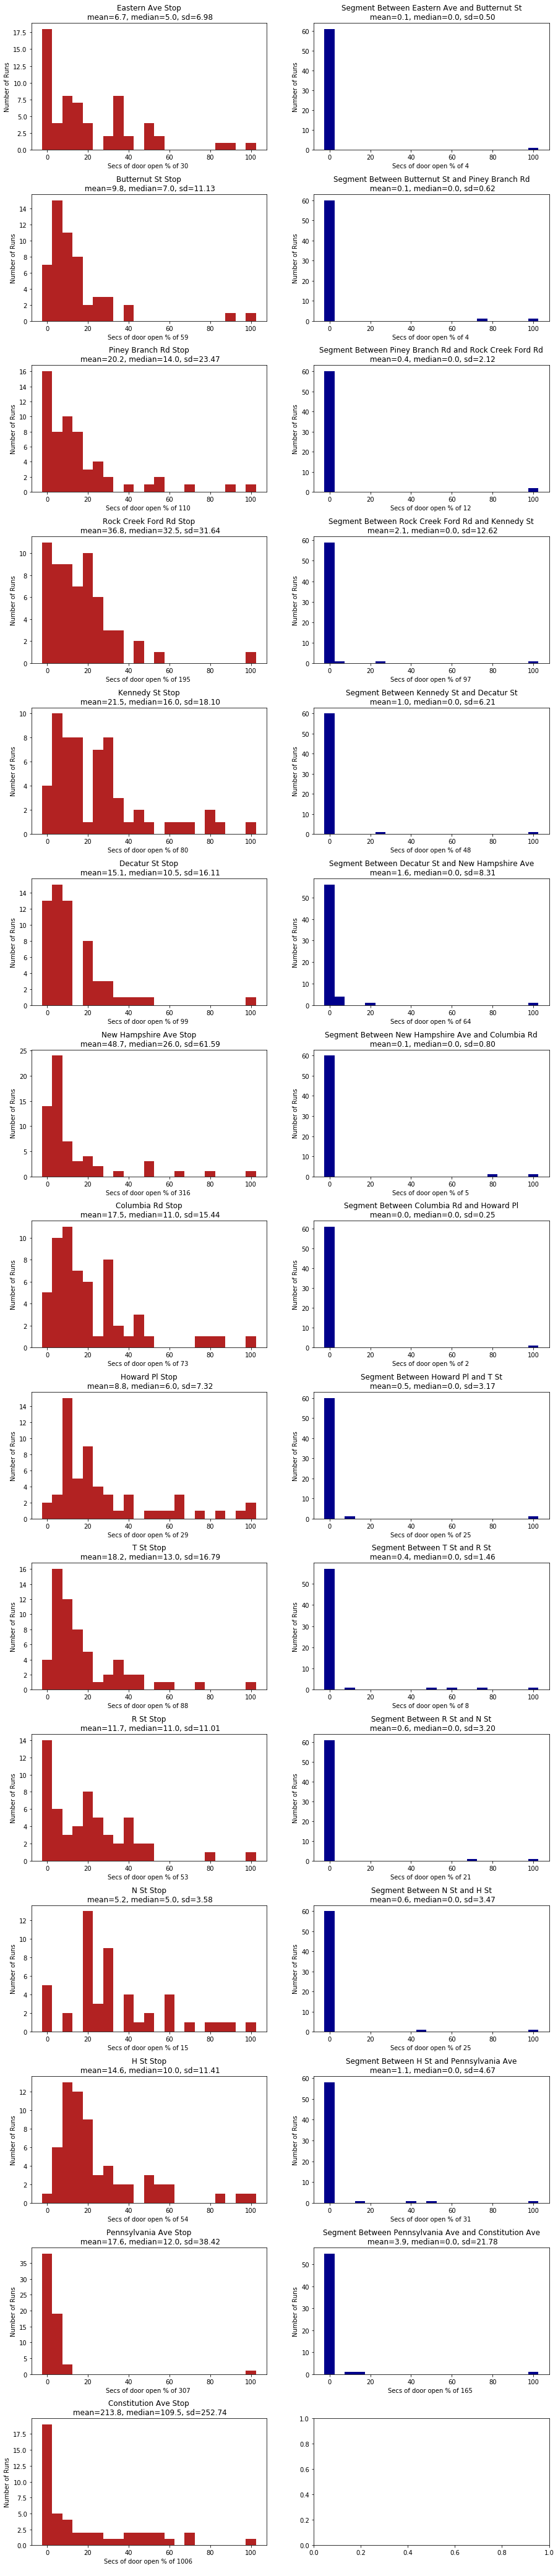

In [40]:
show_segment_hists(segment_door_open, "Secs of door open")

### Time Elapsed while Bus Stationary

Here, predictably, there are non-zero observations both within stop windows and between stop windows. I did not expect to see so few observations in the segments between stops with a stationary time of greater than zero, however. I would expect to see many seconds where the bus is waiting at a stop light for example. **Does this mean that the system does not register these instances properly?**

As previously mentioned, this and the previous metric provide a good proxy for dwell time. This one in particular  can help us exclude forms of delay that are not due to dwell time, i.e. when the bus is  stationary between two stops. When the stationary time is between stops, we can attribute it to signal delay or road congestion. **How could we distinguish between the two, if we wanted?** 

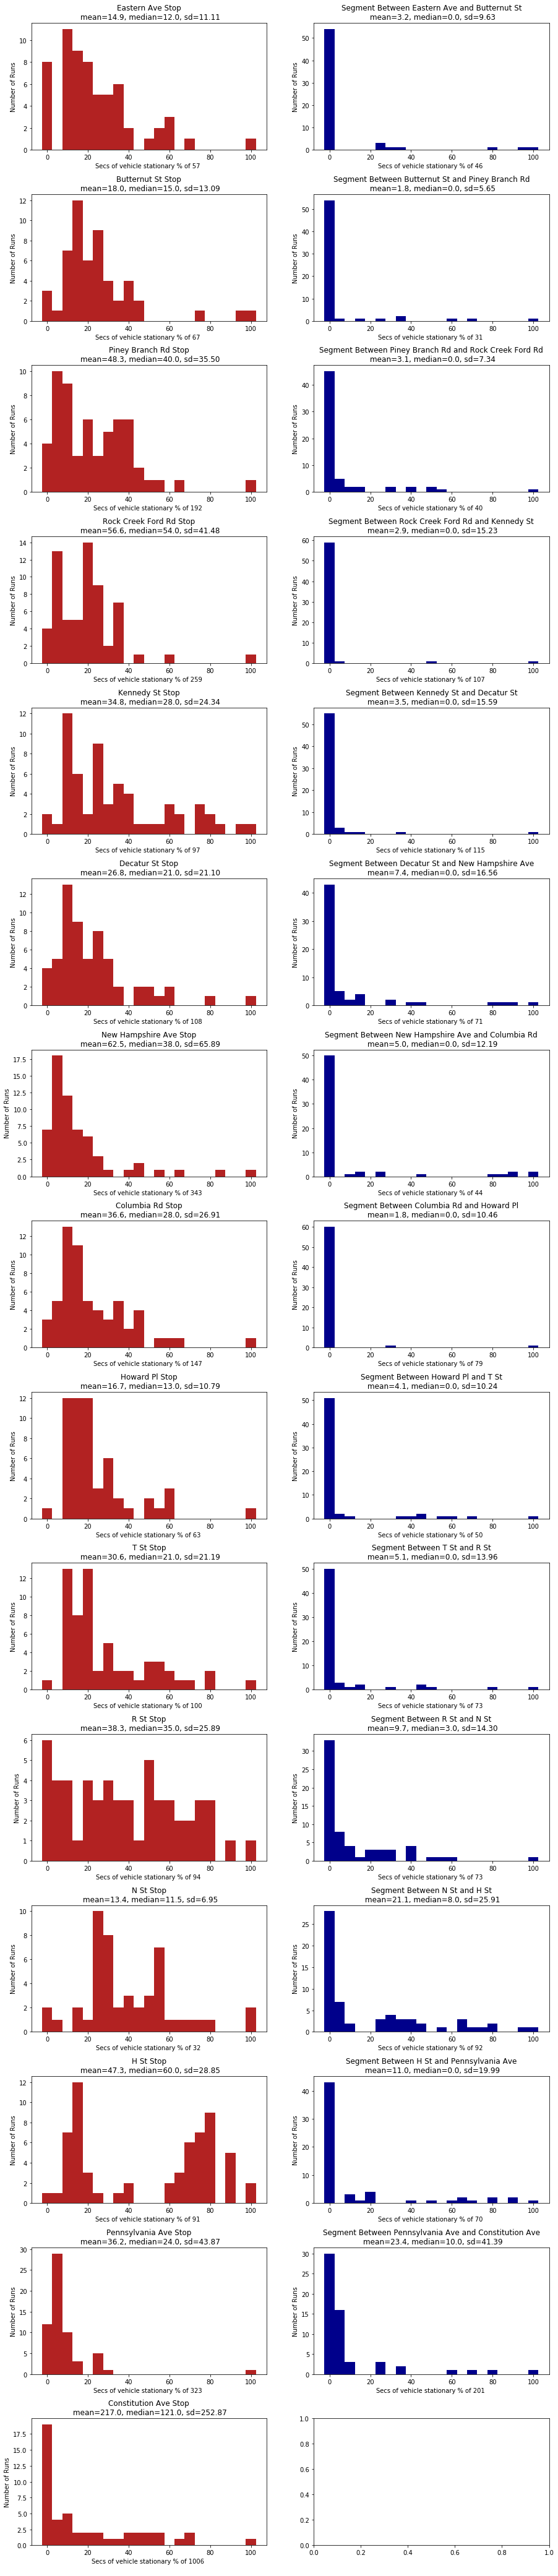

In [41]:
show_segment_hists(segment_stationary, "Secs of vehicle stationary")

### Median vs standard deviation

In [87]:
# Convert below to using above data frames

cols = ['id', 'type', 'stop_n', 'segment_name', 'duration_median', 'speed_median', 'speed_sd', 'door_open_median', 'door_open_sd', 'stationary_median', 'stationary_sd']
summary = pd.DataFrame(columns = cols)

for key, l in segment_speeds.items():
    speeds = l
    door = segment_door_open[key]
    stationary = segment_stationary[key]
    duration = segment_durations[key]
    
    stop_n = int(key[:-1])
    
    if "S" in key:
        tp = "S"
        seg_name = stop_names[int(stop_n)]
    else:
        tp = "P"
        seg_name = stop_names[int(stop_n)-1] + " to " + stop_names[int(stop_n)]
    
    row_list = [key, tp, stop_n, seg_name, np.median(duration), np.median(speeds), np.std(speeds), np.median(door), np.std(door), np.median(stationary), np.std(stationary)]
    
    summary = summary.append(pd.DataFrame([row_list], columns=cols),ignore_index=True)

summary.head()

,id,type,stop_n,segment_name,duration_median,speed_median,speed_sd,door_open_median,door_open_sd,stationary_median,stationary_sd
0,2S,S,2,Eastern Ave,40.0,9.295940,5.555837,5.0,6.981412,12.0,11.108127
1,3P,P,3,Eastern Ave to Butternut St,124.0,31.167187,7.359747,0.0,0.503887,0.0,9.626114
2,3S,S,3,Butternut St,31.0,6.884615,6.652711,7.0,11.129357,15.0,13.093986
3,4P,P,4,Butternut St to Piney Branch Rd,70.0,25.491733,9.422486,0.0,0.624883,0.0,5.654393
4,4S,S,4,Piney Branch Rd,65.5,2.889881,2.464320,14.0,23.468279,40.0,35.501524


In [88]:
summary_p = summary[summary.type=="P"]
summary_s = summary[summary.type=="S"]

In [89]:
def label_point(x, y, val, ax, tp = None):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

The Speed of Inter-Stop Segments

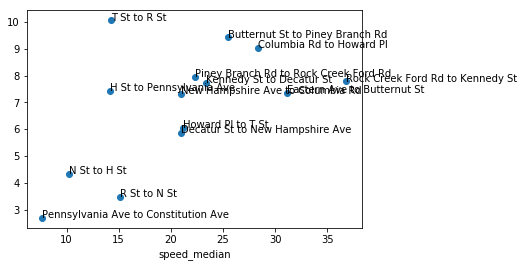

In [93]:
ax = summary_p.set_index('speed_median')['speed_sd'].plot(style='o')
label_point(summary_p.speed_median, summary_p.speed_sd, summary_p.segment_name, ax)

Time Elapsed while Stationary for Inter-Stop Segments

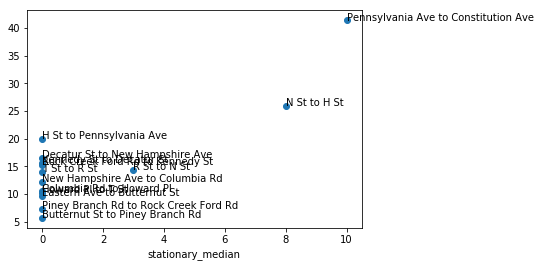

In [94]:
ax = summary_p.set_index('stationary_median')['stationary_sd'].plot(style='o')
label_point(summary_p.stationary_median, summary_p.stationary_sd, summary_p.segment_name, ax)

In [ ]:
# 16 might need to be excluded
summary_p = summary_p[summary_p.stop_n != 16]

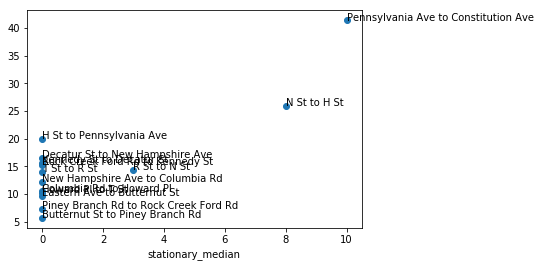

In [95]:
ax = summary_p.set_index('stationary_median')['stationary_sd'].plot(style='o')
label_point(summary_p.stationary_median, summary_p.stationary_sd, summary_p.segment_name, ax)

Time Elapsed while Stationary for Stop Windows

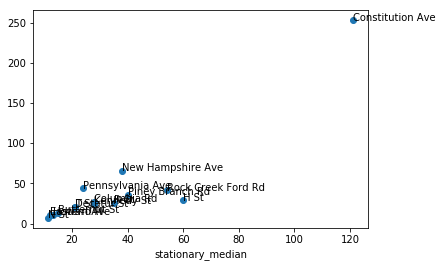

In [96]:
ax = summary_s.set_index('stationary_median')['stationary_sd'].plot(style='o')
label_point(summary_s.stationary_median, summary_s.stationary_sd, summary_s.segment_name, ax)

In [75]:
# 16 is way out. Exclude it.
summary_s = summary_s[summary_s.stop_n != 16]

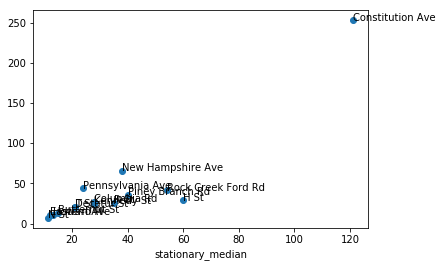

In [97]:
ax = summary_s.set_index('stationary_median')['stationary_sd'].plot(style='o')
label_point(summary_s.stationary_median, summary_s.stationary_sd, summary_s.segment_name, ax)

Time Elapsed while Door Open for Stop Windows

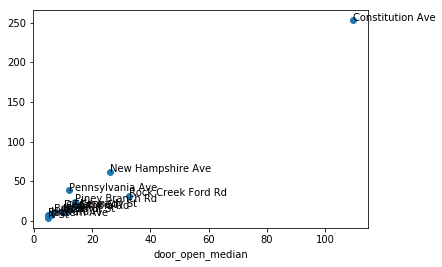

In [98]:
ax = summary_s.set_index('door_open_median')['door_open_sd'].plot(style='o')
label_point(summary_s.door_open_median, summary_s.door_open_sd, summary_s.segment_name, ax)

## Segment Reports

In [79]:
summary.head()

,id,type,stop_n,stop_name,duration_median,speed_median,speed_sd,door_open_median,door_open_sd,stationary_median,stationary_sd
0,2S,S,2,Eastern Ave,40.0,9.295940,5.555837,5.0,6.981412,12.0,11.108127
1,3P,P,3,Eastern Ave to Butternut St,124.0,31.167187,7.359747,0.0,0.503887,0.0,9.626114
2,3S,S,3,Butternut St,31.0,6.884615,6.652711,7.0,11.129357,15.0,13.093986
3,4P,P,4,Butternut St to Piney Branch Rd,70.0,25.491733,9.422486,0.0,0.624883,0.0,5.654393
4,4S,S,4,Piney Branch Rd,65.5,2.889881,2.464320,14.0,23.468279,40.0,35.501524


In [80]:
def get_letter(grade):
    if grade >= 3.67:
        return "A"
    elif grade >= 2.67:
        return "B"
    elif grade >= 1.67:
        return "C"
    elif grade >= 0.67:
        return "D"
    else:
        return "F"

In [81]:
def rate_sw_speed(row):
    mph = row['speed_median']*15/22
    if mph >= 8:
        return 4
    elif mph >= 6:
        return 3
    elif mph >= 4:
        return 2
    elif mph >= 2:
        return 1
    else:
        return 0

In [112]:
def rate_is_speed(row):
    mph = row['speed_median']*15/22
    if mph >= 18:
        return 4
    elif mph >= 12:
        return 3
    elif mph >= 8:
        return 2
    elif mph >= 5:
        return 1
    else:
        return 0

In [83]:
def rate_dwell_time(row):
    dt = row['stationary_median']
    if dt <= 15:
        return 4
    elif dt <= 25:
        return 3
    elif dt <= 40:
        return 2
    elif dt <= 60:
        return 1
    else:
        return 0

In [140]:
def rate_signal(row):
    sig = (row['stationary_median']+2)/row['duration_median']*100
    if sig <= 2:
        return 4
    elif sig <= 4:
        return 3
    elif sig <= 8:
        return 2
    elif sig <= 15:
        return 1
    else:
        return 0

In [137]:
# Stop windows
for index, row in summary_s.iterrows():
    print("Report Card for:", row['segment_name'], "Stop")
    speed_score = rate_sw_speed(row)
    print("Speed Score:", get_letter(speed_score))
    dwell_score = rate_dwell_time(row)
    print("Dwell Time Score:", get_letter(dwell_score))
    gpa = np.mean([speed_score,dwell_score])
    print("Overall Score:", get_letter(gpa))
    print()

Report Card for: Eastern Ave Stop
Speed Score: B
Dwell Time Score: A
Overall Score: B

Report Card for: Butternut St Stop
Speed Score: C
Dwell Time Score: A
Overall Score: B

Report Card for: Piney Branch Rd Stop
Speed Score: F
Dwell Time Score: C
Overall Score: D

Report Card for: Rock Creek Ford Rd Stop
Speed Score: F
Dwell Time Score: D
Overall Score: F

Report Card for: Kennedy St Stop
Speed Score: D
Dwell Time Score: C
Overall Score: D

Report Card for: Decatur St Stop
Speed Score: D
Dwell Time Score: B
Overall Score: C

Report Card for: New Hampshire Ave Stop
Speed Score: F
Dwell Time Score: C
Overall Score: D

Report Card for: Columbia Rd Stop
Speed Score: D
Dwell Time Score: C
Overall Score: D

Report Card for: Howard Pl Stop
Speed Score: C
Dwell Time Score: A
Overall Score: B

Report Card for: T St Stop
Speed Score: D
Dwell Time Score: B
Overall Score: C

Report Card for: R St Stop
Speed Score: F
Dwell Time Score: C
Overall Score: D

Report Card for: N St Stop
Speed Score: C
D

In [141]:
# Inter-stop
for index, row in summary_p.iterrows():
    print("Report Card for:", row['segment_name'])
    speed_score = rate_is_speed(row)
    print("Speed Score:", get_letter(speed_score))
    delay_score = rate_signal(row)
    print("Signal Delay Score:", get_letter(delay_score))
    gpa = np.mean([speed_score,delay_score])
    print("Overall Score:", get_letter(gpa))
    print()

Report Card for: Eastern Ave to Butternut St
Speed Score: A
Signal Delay Score: A
Overall Score: A

Report Card for: Butternut St to Piney Branch Rd
Speed Score: B
Signal Delay Score: B
Overall Score: B

Report Card for: Piney Branch Rd to Rock Creek Ford Rd
Speed Score: B
Signal Delay Score: B
Overall Score: B

Report Card for: Rock Creek Ford Rd to Kennedy St
Speed Score: A
Signal Delay Score: C
Overall Score: B

Report Card for: Kennedy St to Decatur St
Speed Score: B
Signal Delay Score: A
Overall Score: B

Report Card for: Decatur St to New Hampshire Ave
Speed Score: B
Signal Delay Score: A
Overall Score: B

Report Card for: New Hampshire Ave to Columbia Rd
Speed Score: B
Signal Delay Score: A
Overall Score: B

Report Card for: Columbia Rd to Howard Pl
Speed Score: A
Signal Delay Score: B
Overall Score: B

Report Card for: Howard Pl to T St
Speed Score: B
Signal Delay Score: A
Overall Score: B

Report Card for: T St to R St
Speed Score: C
Signal Delay Score: B
Overall Score: C

Rep